**Azure AI Agent with Azure AI Search**


This Python script demonstrates how to set up an Azure AI Agent that leverages Azure AI Search as its knowledge base. By integrating AI Search, the agent can retrieve relevant data from indexed documents and use it to generate responses dynamically.

Key Features:

Utilizes Azure AI Projects to create a conversational AI agent.
Creating an AI agent powered by GPT-4o-mini with azure search index as knowledge base.
Showcases how to configure Azure Search as a tool for an AI assistant.
Provides an interactive command-line interface for real-time interaction.


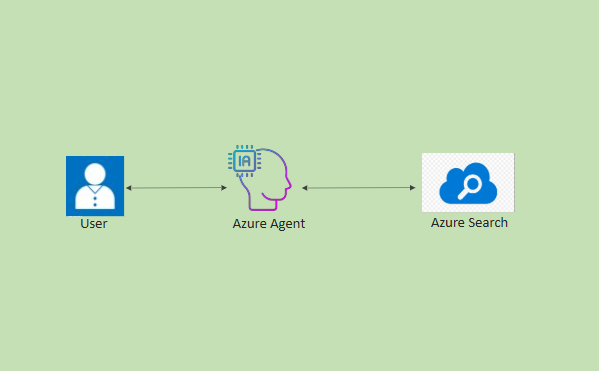

In [ ]:
# Installs the Azure AI Projects SDK and Azure Identity library for authentication
#!pip install azure-ai-projects==1.0.0b7 azure-identity==1.21.0 load_dotenv

In [ ]:
#Configure environment variables for Azure AI Project and Azure search connection ID

import os
from dotenv import load_dotenv
load_dotenv('agents.env')
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
TENANT_ID = os.getenv("TENANT_ID")
PROJECT_ENDPOINT = os.getenv("PROJECT_ENDPOINT")
print(PROJECT_ENDPOINT)


In [ ]:
import os
from azure.ai.projects import AIProjectClient
from azure.identity import ClientSecretCredential
from azure.ai.agents.models import AzureAISearchTool

# Configure Azure credentials
credential = ClientSecretCredential(
    tenant_id=os.getenv("TENANT_ID"),
    client_id=os.getenv("CLIENT_ID"),
    client_secret=os.getenv("CLIENT_SECRET")
)

# Initialize Azure AI Project Client
project_client = AIProjectClient(
    credential=credential,
    endpoint=os.environ["PROJECT_ENDPOINT"],
)

# AI Search resource connection ID
# This code looks for the AI Search Connection ID and saves it as variable conn_id

# If you have more than one AI search connection, try to establish the value in your .env file.
# Extract the connection list.
conn_list = project_client.connections.list()
conn_id = ""

# Search in the metadata field of each connection in the list for the azure_ai_search type and get the id value to establish the variable
# Ensure we have 1 Azure AI Search Connection in your Foundry Project

for conn in conn_list:
    metadata = conn["metadata"]
    if metadata.get("type", "").upper() == "AZURE_AI_SEARCH":
        conn_id = conn["id"]
        break

print(conn_id)


# Get AI Search resource connection ID
#
#conn_id = os.getenv("CONNECTION_ID")

# Initialize AI search tool with the index name
ai_search = AzureAISearchTool(index_connection_id=conn_id, index_name="rag-1760454293806")

# Create the AI agent
agent = project_client.agents.create_agent(
    model=os.environ["MODEL_DEPLOYMENT_NAME"],
    name="my-agent-aisearch",
    instructions="You are a helpful agent to perform RAG Queries using AI Search",
    tools=ai_search.definitions,
    tool_resources=ai_search.resources,
)
print(f"Created agent, ID: {agent.id}")

# Create a conversation thread
thread = project_client.agents.threads.create()
print(f"Created thread, ID: {thread.id}")

# Interactive conversation loop
while True:
    user_input = input("User: ")
    if user_input.lower() == "end":
        project_client.agents.delete_agent(agent.id)
        print("Ending the conversation.")
        break

    # Send user message to the agent
    message = project_client.agents.messages.create(
        thread_id=thread.id,
        role="user",
        content=user_input,
    )

    # Process the agent's run
    run = project_client.agents.runs.create(thread_id=thread.id, agent_id=agent.id)
    print(f"Run finished with status: {run.status}")

    if run.status == "failed":
        print(f"Run failed: {run.last_error}")
        break

    # Retrieve and display agent's response
    latest_message = next(msg for msg in project_client.agents.messages.list(thread_id=thread.id) if msg.role == "assistant")
    if agent_response := next((content.text.value for content in latest_message.content if content.type == "text"), None):
        print(f"Agent: {agent_response}")


print("Conversation ended")
